In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [ ]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "¡HOLA!" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, '¡hola!', va='center', ha='center', weight='bold', size=40)
    fig.savefig('hola.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hola.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

Let's call the function and visualize the resulting data:

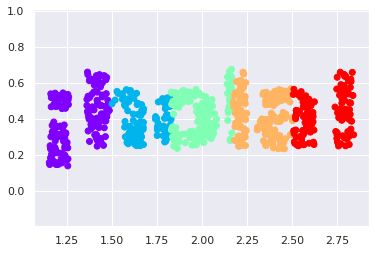

In [ ]:
X = make_hello(2000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

The output is two dimensional, and consists of points drawn in the shape of the word, "HOLA!!". This data form will help us to see visually what the MDS algorithm is doing. 

The *x* and *y* coordinares are not necessarily fundamental to the relationships in the data.
What *is* fundamental, in this case, is the *distance* between each point and the other points in the dataset.
A common way to represent this is to use a distance matrix: for $N$ points, we construct an $N \times N$ array such that entry $(i, j)$ contains the distance between point $i$ and point $j$.

(2) Let's use Scikit-Learn's efficient ``pairwise_distances`` function to do this for our original data:

In [ ]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(744, 744)

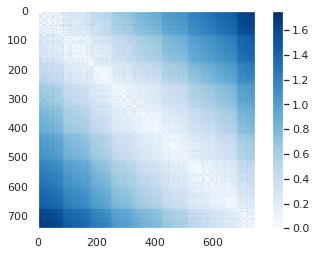

In [ ]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

This distance matrix gives us a representation of our data that is invariant to rotations and translations.
The goal of the multidimensional scaling algorithm is as follows: given a distance matrix between points, it recovers a $q$-dimensional coordinate representation of the data.
Let's see how it works for our distance matrix, using the ``precomputed`` dissimilarity to specify that we are passing a distance matrix.

(3) Using sklearn.manifold, run the MDS algorithm on X and visualize the result.  Discuss the output.

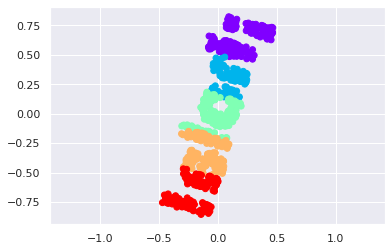

In [ ]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

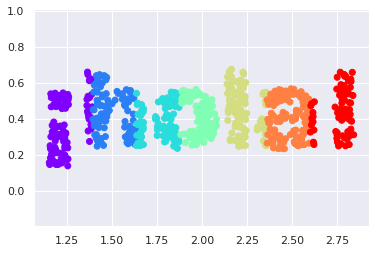

In [ ]:

X = make_hello(2000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 7))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

The MDS algorithm recovers one of the possible two-dimensional coordinate representations of our data, using *only* the $N\times N$ distance matrix describing the relationship between the data points.

The usefulness of this becomes more apparent when we consider the fact that distance matrices can be computed from data in *any* dimension.
We project the data we genrated into three dimensions using the following function.

(4) Using the function random projection, Project the data into three dimensions, call it X3 and visualizethe result.

In [ ]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(744, 3)

Let's visualize these points to see what we're working with:

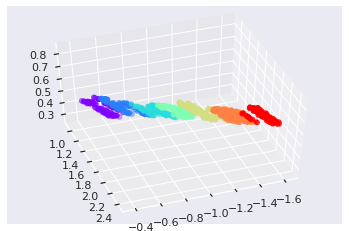

In [ ]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

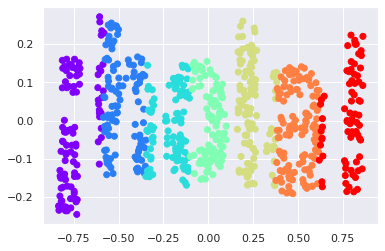

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_hola = pca.fit_transform(X3)
plt.scatter(pca_hola[:,0],pca_hola[:,1], **colorize)

We can now ask the ``MDS`` estimator to input this three-dimensional data, compute the distance matrix, and then determine the optimal two-dimensional embedding for this distance matrix.

(5) Run the MDS algorithm on X3 and visualize the result. Discuss the output.

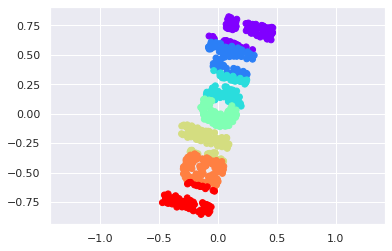

In [ ]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

This is essentially the goal of MDS: given high-dimensional embedded data, it seeks a low-dimensional representation of the data that preserves certain relationships within the data.
In the case of MDS, the quantity preserved is the distance between every pair of points.

**Where MDS fails:** Our discussion thus far has considered *linear* embeddings, which essentially consist of rotations, translations, and scalings of data into higher-dimensional spaces.
Where MDS breaks down is when the embedding is nonlinear—that is, when it goes beyond this simple set of operations.
Consider the following embedding, which takes the input and contorts it into an "S" shape in three dimensions.

(6) Use the function make hello S-curve to generate a nonlinear transformation of the data. Call it XS and visualize the result.

In [ ]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

This is again three-dimensional data, but we can see that the embedding is much more complicated

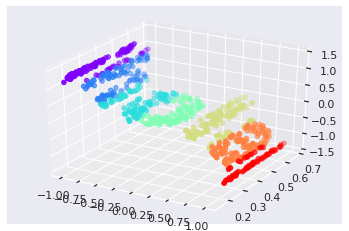

In [ ]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

The fundamental relationships between the data points are still there, but this time the data has been transformed in a nonlinear way: it has been wrapped-up into the shape of an "S."
If we try a simple MDS algorithm on this data, it is not able to "unwrap" this nonlinear embedding, and we lose track of the fundamental relationships in the embedded manifold.

(7) Run the MDS algorithm on XS and visualize the result. Discuss the output.

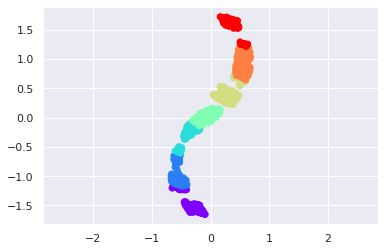

In [ ]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

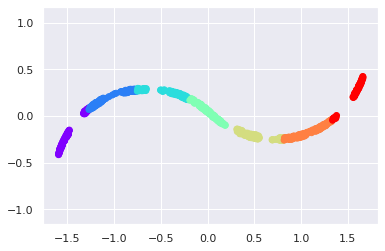

In [ ]:
outS_pca = pca.fit_transform(XS)
plt.scatter(outS_pca[:,0], outS_pca[:,1], **colorize)
plt.axis('equal');

The best two-dimensional linear embeding does not unwrap the S-curve, but instead throws out the original y-axis. There are algorithms that can deal with this non linerity such as Locally Linear Embedding.

# t-student Stochastic Neighbour Embedding (t-SNE)
t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

Let's apply t-SNE to our S shaped "HOLA!!".

(1) Following up from exercise 3, use sklearn to visualize the 3D S-shaped HOLA!! in two-dimensions. Discuss the output.

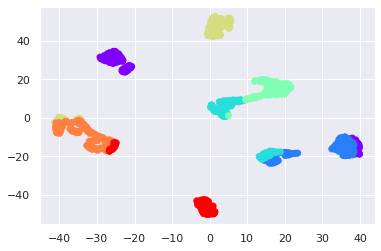

In [ ]:
from sklearn.manifold import TSNE
model = TSNE( n_components=2,perplexity=30)
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
#ax.set_ylim(0.15, -0.15);